In [1]:
import keras
from keras import Sequential
from keras.layers  import Dense, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Helper libraries
import numpy as np  # Keras needs an older version of numpy
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

import json
import pandas as pd
import time

Using TensorFlow backend.


### WAME implmentation

The `WameAdapted` class is defined here and used subsequently

In [2]:
from keras.optimizers import Optimizer
from keras import backend as K


class WameAdapted(Optimizer):
    """
    WAME algorithm as described in Mosca & Maglouas, with square root of theta
    """
    def __init__(self, lr=0.001, beta=0.9, eta_plus=1.2, eta_minus=0.1, zeta_min=0.01, zeta_max=100, **kwargs):
        super(WameAdapted, self).__init__(**kwargs)
        self.iterations = K.variable(0)

        self.lr = K.variable(lr)
        self.beta = K.variable(beta)
        self.eta_plus = K.variable(eta_plus)
        self.eta_minus = K.variable(eta_minus)
        self.zeta_min = zeta_min
        self.zeta_max = zeta_max

    def get_updates(self, params, loss):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        shapes = [K.get_variable_shape(p) for p in params]
        prev_grads = [K.zeros(shape) for shape in shapes]
        thetas = [K.zeros(shape) for shape in shapes]
        zetas = [K.ones(shape) for shape in shapes]
        zs = [K.zeros(shape) for shape in shapes]  # This is different to the papers

        for param, grad, theta, zeta, z, prev_grad in zip(params, grads, thetas, zetas, zs, prev_grads):
            # Line 4 to 8
            zeta_new = K.switch(
                K.greater(grad * prev_grad, 0),
                K.minimum(zeta * self.eta_plus, self.zeta_max),
                K.switch(
                    K.less(grad * prev_grad, 0),
                    K.maximum(zeta * self.eta_minus, self.zeta_min),
                    zeta
                )
            )  # note that I added a 'if gradient = 0 then zeta' condition
            # Line 9
            z_new = (self.beta * z) + (1. - self.beta) * zeta_new
            # Line 10
            theta_new = (self.beta * theta) + (1. - self.beta) * K.square(grad)
            # Line 11, with square root of theta
            weight_delta = - self.lr / z_new * grad / (K.sqrt(theta_new) + 1e-11)
            # Line 12
            new_param = param + weight_delta

            self.updates.append(K.update(theta, theta_new))
            self.updates.append(K.update(param, new_param))
            self.updates.append(K.update(prev_grad, grad))
            self.updates.append(K.update(zeta, zeta_new))
            self.updates.append(K.update(z, z_new))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta': float(K.get_value(self.beta)),
                  'eta_plus': float(K.get_value(self.eta_plus)),
                  'eta_minus': float(K.get_value(self.eta_minus)),
                  'zeta_min': float(K.get_value(self.zeta_min)),
                  'zeta_max': float(self.zeta_max)}
        base_config = super(WameAdapted, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



## Import Landsat

In [3]:
def extract_data_lables(file):
    data, lables = [], []
    with open(file, "r") as f:
        for row in f:
            row = row.split()
            row = [int(i) for i in row]
            lables.append(row.pop(-1))
            data.append(row)
        return np.array(data), np.array(lables)

In [4]:
train_data, train_lables = extract_data_lables("data\landsat\sat.trn")

In [5]:
test_data, test_lables  = extract_data_lables("data\landsat\sat.tst")

In [6]:
print(len(train_data))
print(len(test_data))

4435
2000


### Clean Lables

In [7]:
# decriment to index from zero
train_lables -= 1
test_lables -= 1

In [8]:
class_names = {
    0:'red soil'
    ,1:'cotton crop'
    ,2:'grey soil'
    ,3:'damp grey soil'
    ,4:'soil with vegetation stubble'
    ,5:'mixture class (all types present)'
    ,6:'very damp grey soil'
}

In [9]:
# count class observations in training data
np.bincount(train_lables)

array([1072,  479,  961,  415,  470,    0, 1038], dtype=int64)

## Preprocess Images

In [10]:
# scale pixels to 0-1
train_data = train_data / 255.0
test_data = test_data / 255.0

## One-hot encode lables
Class lables need to be in an n x c array format

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
ohe = OneHotEncoder(sparse=False)
train_y = ohe.fit_transform(train_lables.reshape(-1, 1))
test_y = ohe.transform(test_lables.reshape(-1, 1))

In [13]:
train_data.shape

(4435, 36)

In [14]:
train_y.shape

(4435, 6)

In [15]:
train_y.sum()

4435.0

## Functions for creating and testing neural networks

In [16]:
def create_seq_model(n_hidden=1, n_neurons=36):
    """Create a sequential network with (1) hidden layers and (2) neurons in each layer.
    Hidden layers are dense with relu activation"""
    model = Sequential()
    # First hidden layer
    model.add(Dense(n_neurons, input_dim=36))  # input_dim easier to use than input_shape
    model.add(Activation('relu'))
    # Additional hidden layers
    if n_hidden > 1:
        for i in range(n_hidden-2): # -2, -1 for zero index, -1 for first hidden layer
            model.add(Dense(n_neurons))
            model.add(Activation('relu'))
    # output layer
    model.add(Dense(6))  
    model.add(Activation('softmax'))
    return model

In [17]:
def train_test_model(model, optimiser):
    """Trains a model using 25% validation split each epoch, then tests the model with the best validation performance.
    batch_size = 100, maximum epochs =100"""
    
    model.compile(optimizer=optimiser
              ,loss='categorical_crossentropy'
              ,metrics=['accuracy']
             )
    
    start_t = time.time()
    
    history =  model.fit(
        train_data
        , train_y
        , epochs=100
        , validation_split=0.25
        , verbose=0
        , batch_size=32
        , shuffle = True
        ,callbacks = [
            EarlyStopping(verbose=False, min_delta=0.0001, patience=15, monitor='val_acc', mode='max', restore_best_weights=True),
        #    ModelCheckpoint('TestModel-progress'+str(counter), monitor='val_acc', verbose=False, save_best_only=True)
        ]
    )
    
    time_s = time.time() - start_t
    
    train_loss, train_acc = model.evaluate(train_data,  train_y, verbose = 0)
    test_loss, test_acc = model.evaluate(test_data,  test_y, verbose = 0)
    
    epochs = history.history['val_acc']
    best_epoch = epochs.index(max(epochs))
    total_epochs = len(epochs)
    sec_per_epoch = time_s / total_epochs
    
    return (train_acc, test_acc, train_loss, test_loss, best_epoch, sec_per_epoch, history)   

In [18]:
def train_test_grid(n_hidden_lst, n_neurons_lst, optimiser, json_out, n_experiments=20):
    """Create, train and test multiple models using various structures. 
    Each structure is trialled via multiple experiments. Experiments use a repeated sequence of random seeds.
    Outputs: 
        - a (json-style) list of dictionaries of metrics from the experiments."""
    
    results = []
    
    if isinstance(optimiser, str):
        opt_alias = optimiser
    else:
        opt_alias = type(optimiser).__name__
        
    print( len(n_hidden_lst)*len(n_neurons_lst), 'sets of', n_experiments, 'experiments to perform.')
    
    counter = 0
    for i, n_hidden in enumerate(n_hidden_lst):
        for j, n_neurons in enumerate(n_neurons_lst):
            record_dict = OrderedDict({
                'hidden_layers': n_hidden
                ,'neurons': n_neurons
                ,'optimiser': opt_alias
                ,'n_experiments': n_experiments
                ,'train_accuracies': []
                ,'test_accuracies': []
                ,'train_losses' : []
                ,'test_losses' : []
                ,'best_epochs': []
                ,'seconds_per_epoch': []
            })
            
            for k in range(n_experiments):
                np.random.seed(10+k)
                model = create_seq_model(n_hidden, n_neurons)
                train_acc, test_acc, train_loss, test_loss, best_epoch, sec_per_epoch, _ = train_test_model(model, optimiser)
                record_dict['train_accuracies'].append(train_acc)
                record_dict['test_accuracies'].append(test_acc)
                record_dict['train_losses'].append(train_loss)
                record_dict['test_losses'].append(test_loss)
                record_dict['best_epochs'].append(best_epoch)
                record_dict['seconds_per_epoch'].append(sec_per_epoch)
            
            record_dict['avg_train_acc'] = sum(record_dict['train_accuracies'])/len(record_dict['train_accuracies'])
            record_dict['avg_test_acc'] = sum(record_dict['test_accuracies'])/len(record_dict['test_accuracies'])
            record_dict['avg_epoch'] = sum(record_dict['best_epochs'])/len(record_dict['best_epochs'])
            record_dict['avg_sec_per_epoch'] = sum(record_dict['seconds_per_epoch'])/len(record_dict['seconds_per_epoch'])
            record_dict['min_test_acc'] = min(record_dict['test_accuracies'])
            record_dict['max_test_acc'] = max(record_dict['test_accuracies'])
            record_dict['stdev_test_acc'] = np.std(record_dict['test_accuracies'])
            record_dict['serr_test_acc'] = record_dict['stdev_test_acc'] / (record_dict['n_experiments']**0.5)
            record_dict['CI_95'] = record_dict['serr_test_acc'] * 1.96
            
            results.append(record_dict)
            counter += 1
            with open(json_out, 'w') as f:
                json.dump(results, f)
            print(counter, 'sets done')
    print('done!')
    return results

##### Test various 'adam' configurations

Note: after running once the `train_test_grid` function is commented-out: on subsequent runs the previous results are loaded from the output jsons. 

Un-commenting the applicable lines of code will run the experiments from scratch and over-write the previous jsons.

In [19]:
n_hidden_lst = [1, 2, 3, 4]
n_neurons_lst = [10, 20, 30, 40]

In [20]:
# RUN ONCE:
# Commented out after running 
# adam_results = train_test_grid(n_hidden_lst, n_neurons_lst, 'adam', 'results/adam_results.json.txt', n_experiments=20)

In [21]:
# Henceforth, load results from json
with open('results/adam_results.json.txt', 'r') as f:
    adam_results = json.load(f)

#### Test various WAME configurations using WAME that is almost the same as the paper except with sqrt theta

In [22]:
# RUN ONCE:
# Commented out after running 
# wameAdapted_results = train_test_grid(n_hidden_lst, n_neurons_lst, WameAdapted(), 'results/wameAdapted_results.json.txt', n_experiments=20)

In [23]:
# Henceforth, load results from json
with open('results/wameAdapted_results.json.txt', 'r') as f:
    wameAdapted_results = json.load(f)

#### Helper functions for reporting results

In [24]:
def best_test(results):
    """Helper function to retrieve the dictionary with the best average test accuracy from a results list"""
    best_result = results[0]
    best_test = results[0]['avg_test_acc']
    for r in results:
        if r['avg_test_acc'] > best_test:
            best_test = r['avg_test_acc']
            best_result = r
    return r

In [25]:
def retrieve_experiment(results, conditions):
    """results - dictionary output of train_test_grid()
    conditions - a dictionary of keys and values that we want to match
    will return the first experiment to match"""
    for r in results:
        matched = True
        for k, v in conditions.items():
            if r[k] != v:
                matched = False
                break
        if matched:
            return r

def print_kpis(r):
    print('test_acc', round(r['avg_test_acc']*100,1))
    print('+- \t', round(r['CI_95']*100,1))
    print('stdev\t', round(r['stdev_test_acc']*100,1))
    print('epoch\t', round(r['avg_epoch'],1))
    print('time\t', round(r['avg_sec_per_epoch'],2))
    

#### Manually retrieve results for reporting
Edit and run to retrieve a given experiment and its key metrics

In [26]:
# For reporting: manually specify a configuration to print KPIs for the report
conditions = {'hidden_layers': 1
              ,'neurons': 40}

# change to the results set that you want to query:
print_kpis(retrieve_experiment(wameAdapted_results, conditions))

test_acc 47.4
+- 	 5.7
stdev	 13.0
epoch	 22.4
time	 0.36


## Box and Whisker Plots

In [27]:
def df_from_results(results):
    """Helper function to create a tidy DataFrame from a results set. 
    Tidy dataframe is an easier format for data viz. and tabulation
    The format of the DF is that there is a row per experiment (e.g. 20 experiments per arrangement)"""
    
    contents = []
    for r in results:
        col1 = r['optimiser']
        col2 = r['hidden_layers']
        col3 = r['neurons']
        for e in range(r['n_experiments']):
            col4 = r['train_accuracies'][e]
            col5 = r['test_accuracies'][e]
            contents.append([col1, col2, col3, col4, col5])
    
    df = pd.DataFrame(contents, columns=['optimiser','hidden_layers', 'neurons','train_accuracy', 'test_accuracy'])
    return df

### Adam Figures

In [28]:
df_adam = df_from_results(adam_results)

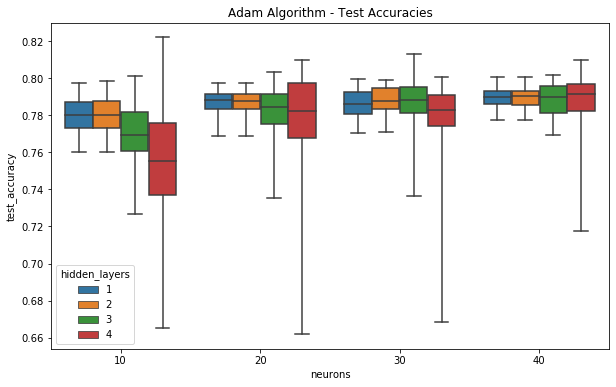

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='neurons',y='test_accuracy',data=df_adam, hue='hidden_layers', whis=[0,100]).set_title('Adam Algorithm - Test Accuracies');

In [30]:
#sns.boxplot(x='hidden_layers',y='test_accuracy',data=df_test, hue='neurons');

### WAME Figures

In [31]:
df_wame = df_from_results(wameAdapted_results)

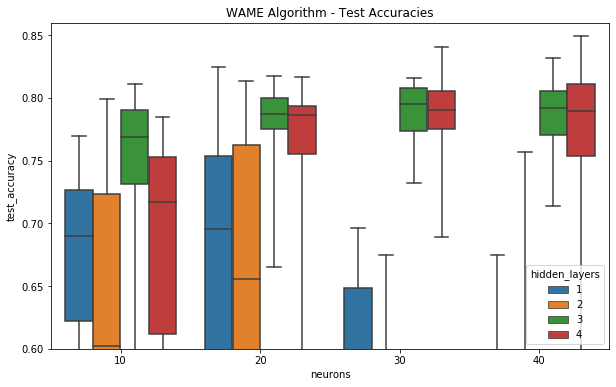

In [32]:
plt.figure(figsize=(10, 6))
axes = plt.axes()
axes.set_ylim([0.6, 0.86])
sns.boxplot(x='neurons',y='test_accuracy',data=df_wame, hue='hidden_layers', whis=[0,100]).set_title('WAME Algorithm - Test Accuracies');

## Test different WAME Parameters

Using a network which achieved reasonable performance: 3 hidden layers and 30 neurons

In [33]:
def fit_get_history(optimiser, exp=1):
    """Trains 2x20 model with the optimiser [exp] times. 
    Returns the loss per epoch, averaged over the experiments """
    train_loss = []
    for i in range(exp):
        model = create_seq_model(n_hidden=3, n_neurons=30)
        model.compile(optimizer=optimiser
                  ,loss='categorical_crossentropy'
                  ,metrics=['accuracy']
                 )
        history =  model.fit(
            train_data
            , train_y
            , epochs=40
            , validation_split=0.25
            , verbose=0
            , batch_size=32
            , shuffle = True
        )
        train_loss.append(history.history['loss'])
    return np.average(train_loss, axis=0)

In [34]:
loss_1_1 = fit_get_history(WameAdapted(eta_plus=1.1), exp=5)
loss_1_2 = fit_get_history(WameAdapted(eta_plus=1.2), exp=5)
loss_1_3 = fit_get_history(WameAdapted(eta_plus=1.3), exp=5)
loss_1_4 = fit_get_history(WameAdapted(eta_plus=1.4), exp=5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


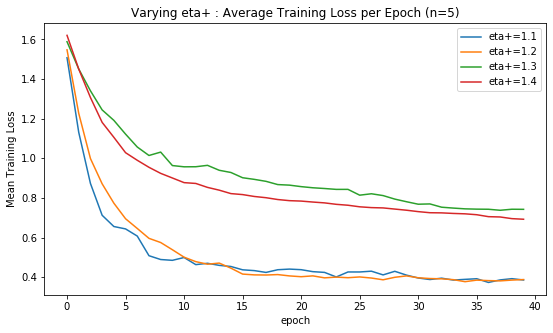

In [35]:
plt.figure(figsize=(9, 5))
plt.plot(loss_1_1)
plt.plot(loss_1_2)
plt.plot(loss_1_3)
plt.plot(loss_1_4)
plt.title('Varying eta+ : Average Training Loss per Epoch (n=5)')
plt.ylabel('Mean Training Loss')
plt.xlabel('epoch')
plt.legend(['eta+=1.1', 'eta+=1.2', 'eta+=1.3', 'eta+=1.4'], loc='upper right')
plt.show()

In [37]:
loss_1 = fit_get_history(WameAdapted(eta_minus=0.08), exp=5)
loss_2 = fit_get_history(WameAdapted(eta_minus=0.1), exp=5)
loss_3 = fit_get_history(WameAdapted(eta_minus=0.12), exp=5)
loss_4 = fit_get_history(WameAdapted(eta_minus=0.14), exp=5)

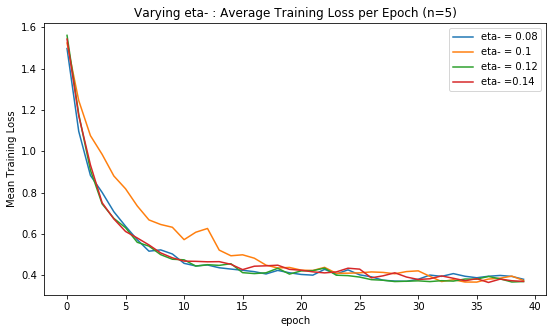

In [38]:
plt.figure(figsize=(9, 5))
plt.plot(loss_1)
plt.plot(loss_2)
plt.plot(loss_3)
plt.plot(loss_4)
plt.title('Varying eta- : Average Training Loss per Epoch (n=5)')
plt.ylabel('Mean Training Loss')
plt.xlabel('epoch')
plt.legend(['eta- = 0.08', 'eta- = 0.1', 'eta- = 0.12', 'eta- =0.14'], loc='upper right')
plt.show()

In [39]:
loss_1 = fit_get_history(WameAdapted(lr=0.001), exp=5)
loss_2 = fit_get_history(WameAdapted(eta_minus=0.01), exp=5)
loss_3 = fit_get_history(WameAdapted(eta_minus=0.1), exp=5)

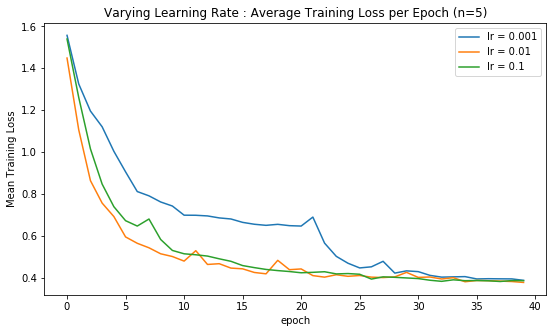

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(loss_1)
plt.plot(loss_2)
plt.plot(loss_3)
plt.title('Varying Learning Rate : Average Training Loss per Epoch (n=5)')
plt.ylabel('Mean Training Loss')
plt.xlabel('epoch')
plt.legend(['lr = 0.001', 'lr = 0.01', 'lr = 0.1'], loc='upper right')
plt.show()